In [1]:
# ==============================================================================
# CELL 1: SETUP AND IMPORTS
# ==============================================================================
import os
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import kagglehub

print("All libraries imported successfully.")


All libraries imported successfully.


In [2]:
# ==============================================================================
# CELL 2: DOWNLOAD AND PREPARE DATASET
# ==============================================================================
# --- Download from Kaggle ---
print("Downloading dataset from Kaggle Hub...")
path = kagglehub.dataset_download("mrnotalent/braint")
print(f"Path to dataset files: {path}")

# --- Copy to a writable directory ---
# This is necessary as the Kaggle input directory is read-only
src = path
dst = '/content/braint_original'
shutil.copytree(src, dst, dirs_exist_ok=True)
print(f"Dataset copied to {dst}")

100%|██████████| 1.22G/1.22G [00:11<00:00, 111MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mrnotalent/braint/versions/1
Dataset copied to /content/braint_original


In [3]:
# ==============================================================================
# CELL 3: CREATE TRAIN / VALIDATION / TEST SPLIT
# ==============================================================================
# --- Step A: Define paths and create the new directory structure ---
original_base_dir = '/content/braint_original'
new_base_dir = '/content/data'

class_names = [d for d in os.listdir(original_base_dir) if os.path.isdir(os.path.join(original_base_dir, d))]
print(f"Found {len(class_names)} classes: {class_names[:5]}...") # Print first 5 classes

# Create train/val/test directories
for split in ['train', 'val', 'test']:
    for class_name in class_names:
        os.makedirs(os.path.join(new_base_dir, split, class_name), exist_ok=True)

# --- Step B: Gather all file paths and labels ---
all_files = []
for class_name in class_names:
    class_dir = os.path.join(original_base_dir, class_name)
    for fname in os.listdir(class_dir):
        if os.path.isfile(os.path.join(class_dir, fname)):
            all_files.append({'path': os.path.join(class_dir, fname), 'label': class_name})

df = pd.DataFrame(all_files)

# --- Step C: Stratified split into train, validation, and test sets ---
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['label'])

print(f"\nTotal images: {len(df)}")
print(f"Training size: {len(train_df)} (70%)")
print(f"Validation size: {len(val_df)} (15%)")
print(f"Test size: {len(test_df)} (15%)")

# --- Step D: Copy files into the new directories ---
def copy_files(dataframe, split_name):
    for _, row in dataframe.iterrows():
        src_path = row['path']
        dst_path = os.path.join(new_base_dir, split_name, row['label'], os.path.basename(src_path))
        shutil.copy(src_path, dst_path)
    print(f"Finished copying {split_name} files.")

copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')
print("\nData splitting and structuring complete.")

Found 44 classes: ['Astrocitoma T1', 'Meningioma T1C+', 'Meduloblastoma T2', '_NORMAL T1', 'Glioblastoma T2']...

Total images: 16236
Training size: 11365 (70%)
Validation size: 2435 (15%)
Test size: 2436 (15%)
Finished copying train files.
Finished copying val files.
Finished copying test files.

Data splitting and structuring complete.


In [4]:
# ==============================================================================
# CELL 4: DEFINE TRANSFORMS AND DATALOADERS
# ==============================================================================
IMG_SIZE = 224

# --- Define conservative medical image augmentations ---
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0]==1 else t), # Handle grayscale
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0]==1 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- Create Datasets and DataLoaders ---
data_dir = '/content/data'
train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_tfms)
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_tfms)
test_ds = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("\nDataLoaders are ready.")


DataLoaders are ready.


In [5]:
# ==============================================================================
# CELL 5: DEFINE THE HYBRID CNN MODEL
# ==============================================================================
class HybridCNN(nn.Module):
    def __init__(self, num_classes, pretrained=True, freeze_backbones=True, hidden=1024, p=0.3):
        super().__init__()
        r_weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        d_weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None

        # --- Backbone A: ResNet50 ---
        self.resnet = models.resnet50(weights=r_weights)
        self.resnet.fc = nn.Identity()

        # --- Backbone B: DenseNet121 ---
        self.densenet = models.densenet121(weights=d_weights)
        self.densenet.classifier = nn.Identity()

        feat_dim = 2048 + 1024 # ResNet50 output + DenseNet121 output

        if freeze_backbones:
            for m in [self.resnet, self.densenet]:
                for p_ in m.parameters():
                    p_.requires_grad = False

        # --- Fusion + Classifier Head ---
        self.head = nn.Sequential(
            nn.Linear(feat_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.densenet(x)
        fused = torch.cat([f1, f2], dim=1)
        return self.head(fused)

print("HybridCNN model class defined.")

HybridCNN model class defined.


In [6]:
# ==============================================================================
# CELL 6: TRAINING AND EVALUATION LOOP
# ==============================================================================
# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridCNN(num_classes=len(class_names), pretrained=True, freeze_backbones=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# --- Training and Evaluation Functions ---
def train_one_epoch():
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

# --- Main Training Loop ---
EPOCHS = 20
best_acc, best_path = 0.0, "hybrid_brain_tumor_best.pth"
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

print(f"Starting training for {EPOCHS} epochs on {device}...")
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch()
    va_loss, va_acc = evaluate(val_loader)
    scheduler.step()

    train_losses.append(tr_loss)
    train_accuracies.append(tr_acc)
    val_losses.append(va_loss)
    val_accuracies.append(va_acc)

    print(f"Epoch {epoch:02d} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {va_loss:.4f} Acc {va_acc:.4f}")

    if epoch == 5:
        print("→ Unfreezing backbones for fine-tuning...")
        for p in model.parameters(): p.requires_grad = True
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=15)

    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({"state_dict": model.state_dict(), "classes": train_ds.classes}, best_path)
        print(f"✓ Saved new best model to {best_path} (val acc {best_acc:.4f})")

print(f"\nFinished Training. Best Validation Accuracy: {best_acc:.4f}")

# --- Final Evaluation on Test Set ---
print("\nPerforming final evaluation on the unseen test set...")
model.load_state_dict(torch.load(best_path)["state_dict"])
test_loss, test_acc = evaluate(test_loader)
print(f"FINAL TEST RESULTS -> Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 91.3MB/s]


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 63.4MB/s]


Starting training for 20 epochs on cuda...
Epoch 01 | Train Loss 2.7055 Acc 0.2870 | Val Loss 1.8234 Acc 0.5162
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.5162)
Epoch 02 | Train Loss 1.7269 Acc 0.5123 | Val Loss 1.4226 Acc 0.6062
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.6062)
Epoch 03 | Train Loss 1.3773 Acc 0.6075 | Val Loss 1.2539 Acc 0.6452
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.6452)
Epoch 04 | Train Loss 1.1970 Acc 0.6554 | Val Loss 1.1098 Acc 0.6710
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.6710)
Epoch 05 | Train Loss 1.0577 Acc 0.6952 | Val Loss 1.0003 Acc 0.7105
→ Unfreezing backbones for fine-tuning...
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.7105)
Epoch 06 | Train Loss 0.7099 Acc 0.7833 | Val Loss 0.4546 Acc 0.8719
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.8719)
Epoch 07 | Train Loss 0.2637 Acc 0.9217 | Val Loss 0.3122 Acc 0.9055
✓ Save

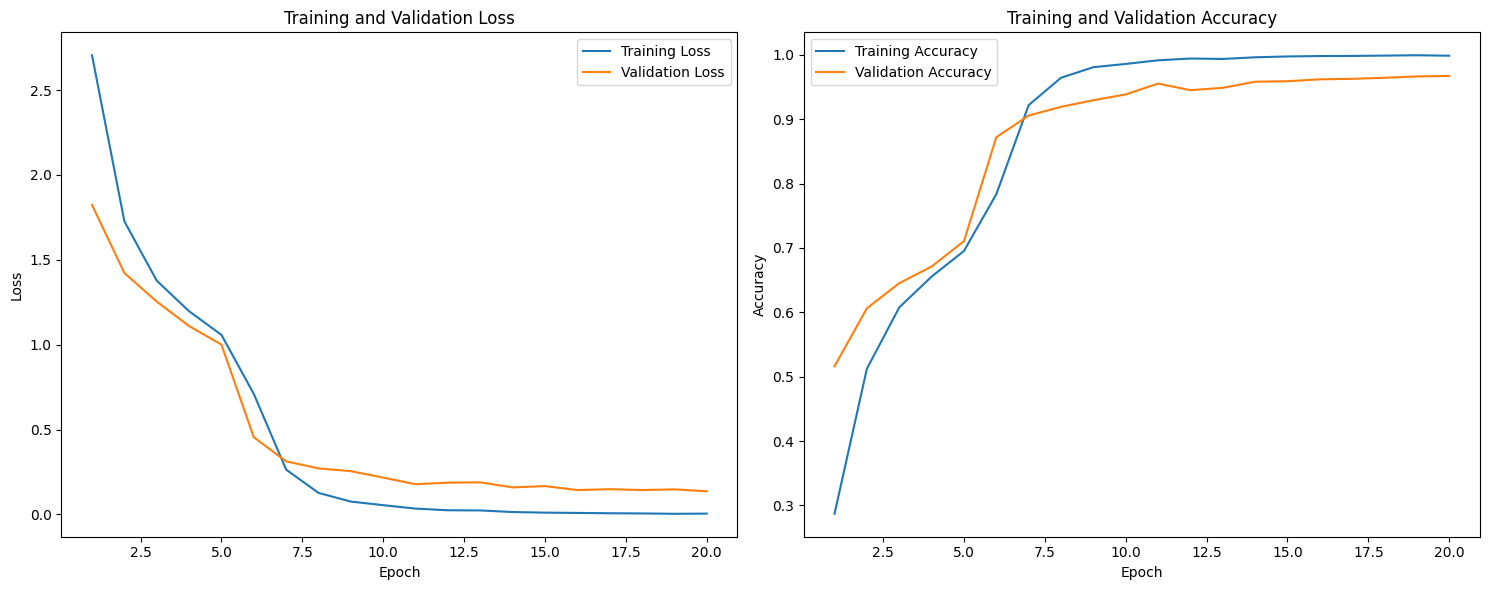

In [7]:
# ==============================================================================
# CELL 7: PLOT TRAINING HISTORY
# ==============================================================================
plt.figure(figsize=(15, 6))
epochs_range = range(1, EPOCHS + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



Generating final report and confusion matrix on the TEST SET...

Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1     1.0000    0.9286    0.9630        56
      Astrocitoma T1C+     0.9138    0.9464    0.9298        56
        Astrocitoma T2     0.9796    0.8571    0.9143        56
          Carcinoma T1     1.0000    0.9455    0.9720        55
        Carcinoma T1C+     0.9818    0.9818    0.9818        55
          Carcinoma T2     0.9815    0.9636    0.9725        55
         Ependimoma T1     0.9474    0.9818    0.9643        55
       Ependimoma T1C+     0.9322    1.0000    0.9649        55
         Ependimoma T2     0.8852    0.9818    0.9310        55
      Ganglioglioma T1     0.9825    1.0000    0.9912        56
    Ganglioglioma T1C+     1.0000    0.9818    0.9908        55
      Ganglioglioma T2     0.9655    1.0000    0.9825        56
          Germinoma T1     0.9643    0.9818    0.9730        55
        Germin

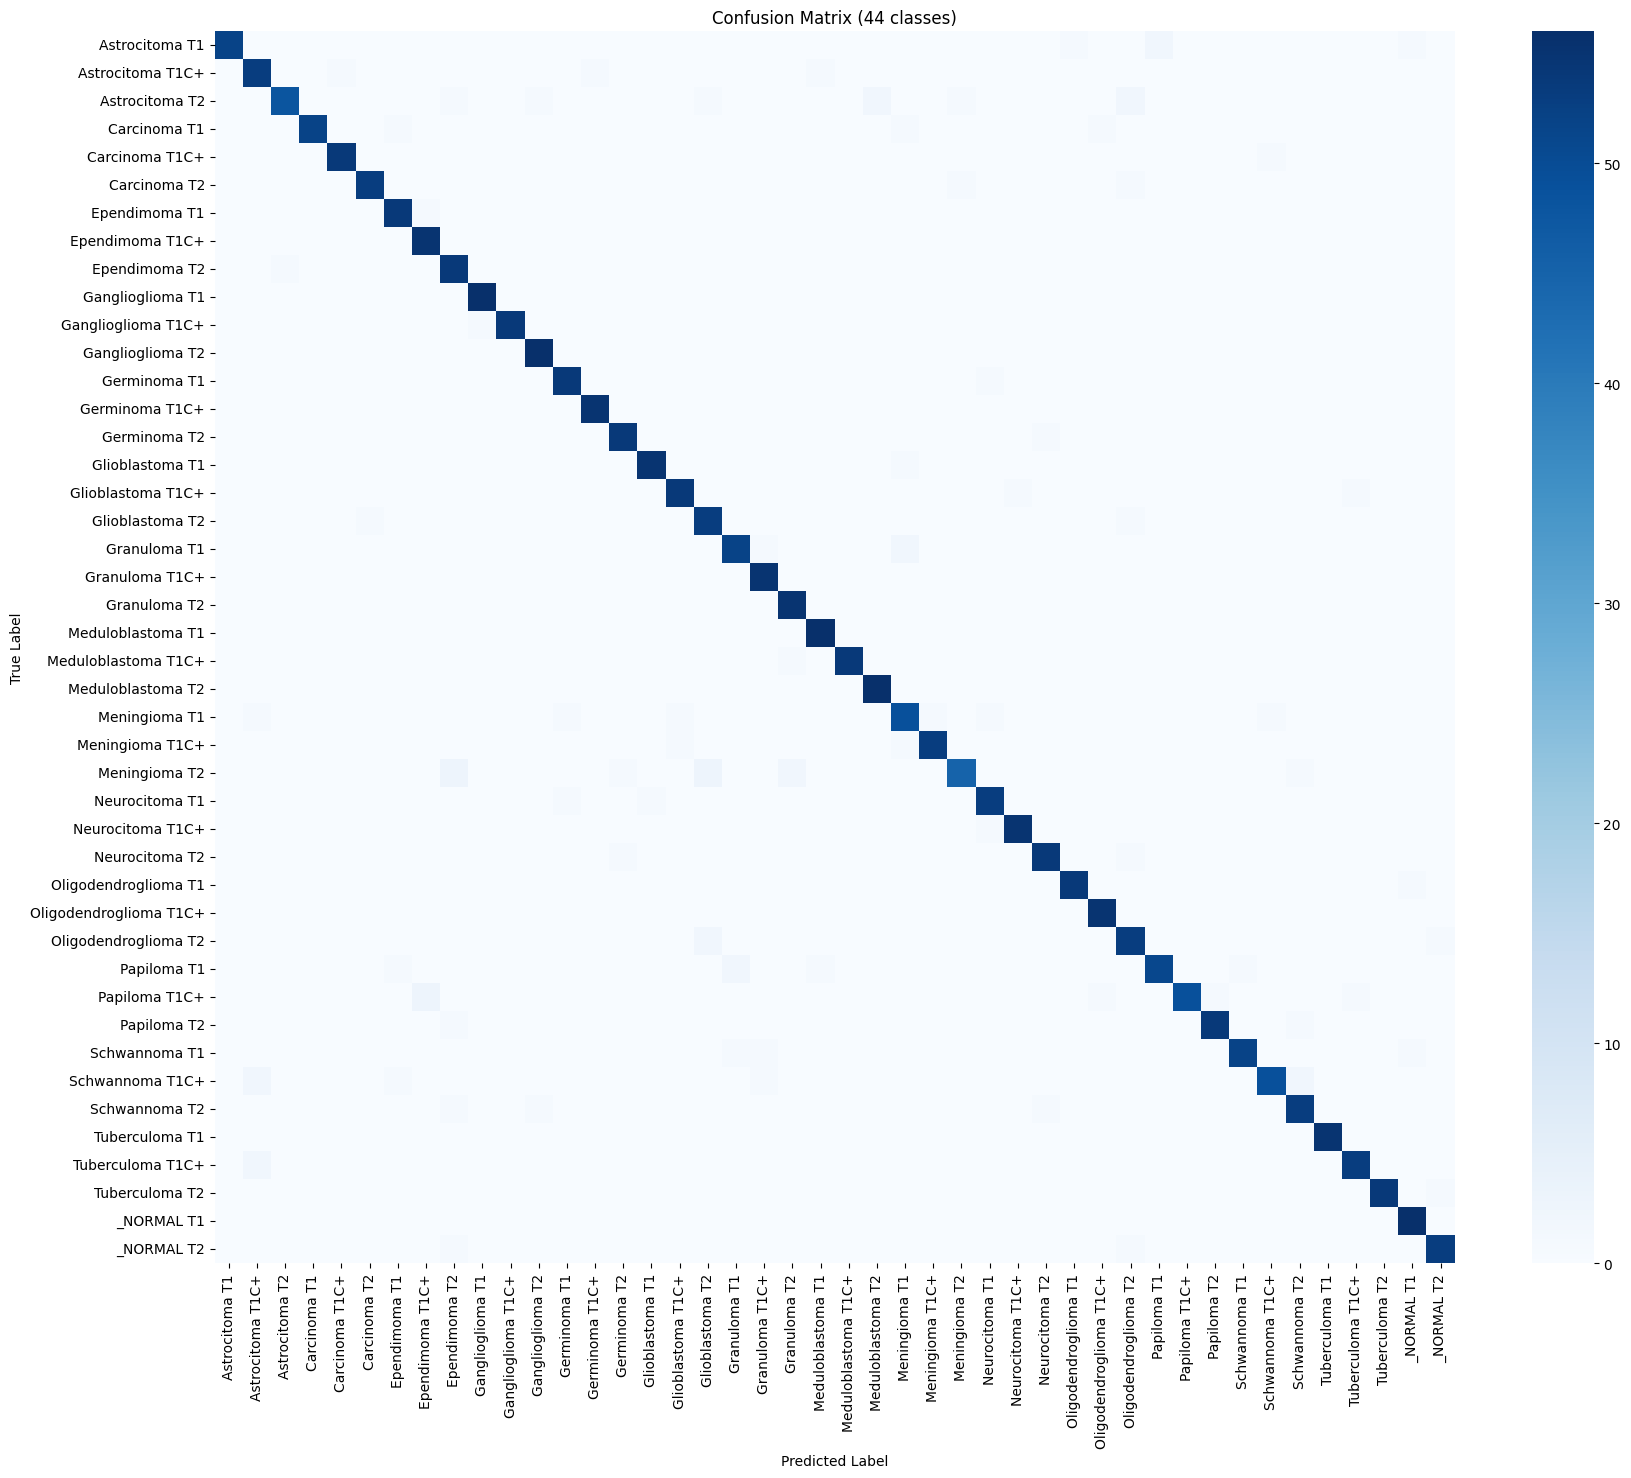

In [8]:
# ==============================================================================
# CELL 8: DETAILED REPORT AND CONFUSION MATRIX ON TEST SET
# ==============================================================================
print("\nGenerating final report and confusion matrix on the TEST SET...")
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_ds.classes, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.title(f"Confusion Matrix ({len(test_ds.classes)} classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

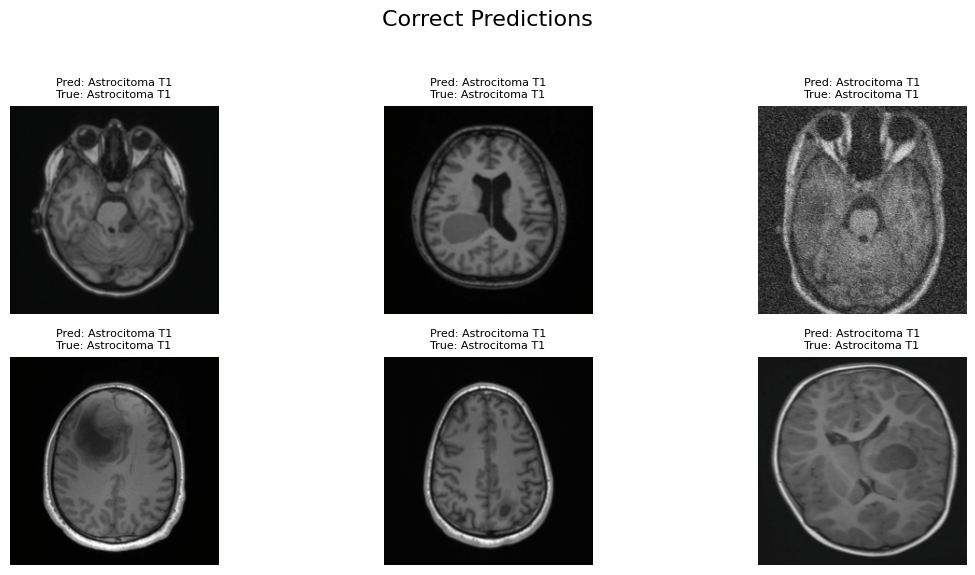

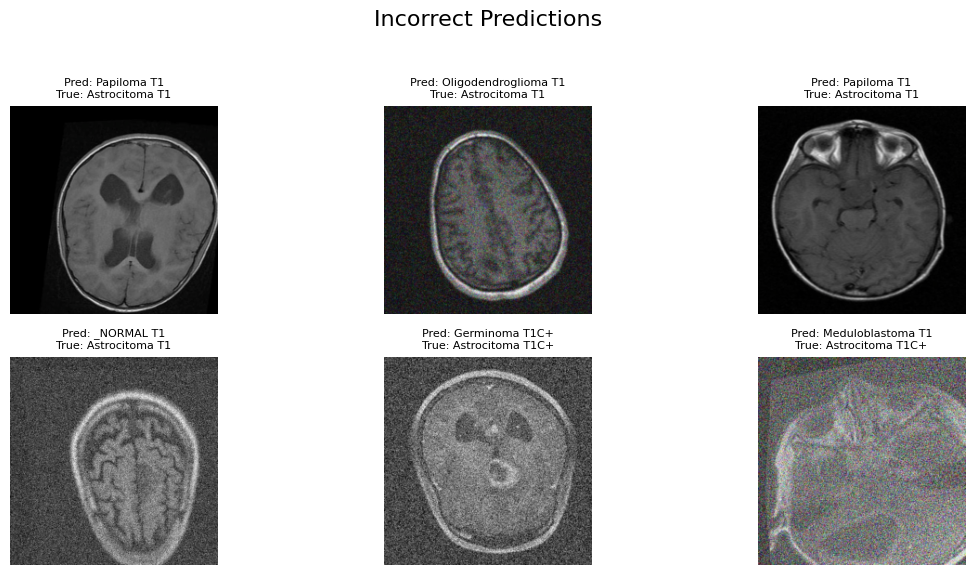

In [9]:
# ==============================================================================
# CELL 9: QUALITATIVE ANALYSIS (ERROR VISUALIZATION)
# ==============================================================================
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=8)
    plt.axis('off')

correct_samples, incorrect_samples = [], []
num_to_show = 6

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        for i in range(images.size(0)):
            if len(correct_samples) < num_to_show and preds[i] == labels[i].to(device):
                correct_samples.append({'image': images[i], 'pred': preds[i].item(), 'true': labels[i].item()})
            elif len(incorrect_samples) < num_to_show and preds[i] != labels[i].to(device):
                incorrect_samples.append({'image': images[i], 'pred': preds[i].item(), 'true': labels[i].item()})
        if len(correct_samples) >= num_to_show and len(incorrect_samples) >= num_to_show:
            break

# --- Plot Correct Predictions ---
fig = plt.figure(figsize=(12, 6))
plt.suptitle("Correct Predictions", fontsize=16)
for i, sample in enumerate(correct_samples):
    ax = plt.subplot(2, 3, i + 1)
    title = f"Pred: {test_ds.classes[sample['pred']]}\nTrue: {test_ds.classes[sample['true']]}"
    imshow(sample['image'], title=title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Plot Incorrect Predictions ---
fig = plt.figure(figsize=(12, 6))
plt.suptitle("Incorrect Predictions", fontsize=16)
for i, sample in enumerate(incorrect_samples):
    ax = plt.subplot(2, 3, i + 1)
    title = f"Pred: {test_ds.classes[sample['pred']]}\nTrue: {test_ds.classes[sample['true']]}"
    imshow(sample['image'], title=title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()